# 1. 第一次作业

In [43]:
# 查看当前挂载的数据集目录
!ls /home/aistudio/data/

data116  data760


In [44]:
# 查看个人持久化工作区文件
!ls /home/aistudio/work/

In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [46]:
import paddle
import sys
import paddle.fluid as fluid
from paddle.fluid.contrib.trainer import *
from paddle.fluid.contrib.inferencer import *

In [47]:
print(sys.version)
print(paddle.__version__)

3.5.5 | packaged by conda-forge | (default, Jul 23 2018, 23:45:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
1.4.1


In [48]:
df=pd.read_csv('data/data116/HousePriceLinearRegressionData.txt',names=['面积','房价'])
df.head()

,面积,房价
0,98.87,599.0
1,68.74,450.0
2,89.24,440.0
3,129.19,780.0
4,61.64,450.0


In [49]:
data=np.loadtxt('data/data116/HousePriceLinearRegressionData.txt',delimiter=',')
data[:10]

array([[ 98.87, 599.  ],
       [ 68.74, 450.  ],
       [ 89.24, 440.  ],
       [129.19, 780.  ],
       [ 61.64, 450.  ],
       [ 74.  , 315.  ],
       [124.07, 998.  ],
       [ 65.  , 435.  ],
       [ 57.52, 435.  ],
       [ 60.42, 225.  ]])

In [50]:
max_data,min_data,avg_data,var_data= data.max(axis=0),data.min(axis=0),data.mean(axis=0),data.var(axis=0)
print(max_data,min_data,avg_data,var_data)

[ 199.96 2000.  ] [ 40.09 202.  ] [ 94.64454023 608.25057471] [ 1094.76662502 78143.72341921]


In [51]:
norm_data=data.copy()
print(norm_data)
norm_data[:,0]=(data[:,0]-avg_data[0])/(max_data[0]-min_data[0])
print(norm_data[:,0].max(),norm_data[:,1].min())

[[ 98.87 599.  ]
 [ 68.74 450.  ]
 [ 89.24 440.  ]
 ...
 [ 89.   735.  ]
 [ 59.53 360.  ]
 [ 97.   600.  ]]
0.6587568635148239 202.0


In [52]:
ratio=0.8
train_index=int(norm_data.shape[0]*ratio)
train_data=norm_data[:train_index]
test_data=norm_data[train_index:]
print(len(train_data),len(test_data))

696 174


import random
def reader(data,batch_size):
    index=list(range(len(data)))
    random.shuffle(index)
    for i in range(0,len(data),batch_size):
        yield data.take(index[i,np.min(i+batch_size,len(data))])

def train(batch_size):
    global train_data
    return reader(train_data,batch_size)

def test_data(batch_size):
    global test_data
    return reader(test_data,batch_size)

In [53]:
def read_data(data_set):
    def reader():
        for data in data_set:
            yield data[:-1],data[-1:]
    return reader

def train():
    global train_data
    return read_data(train_data)
    
def test():
    global test_data
    return read_data(test_data)

In [54]:
use_cuda=False
place=fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

In [55]:
x=fluid.layers.data(name='x',shape=[1],dtype='float32')
y=fluid.layers.data(name='y',shape=[1],dtype='float32')
y_predict=fluid.layers.fc(input=x,size=1,act=None)

In [56]:
loss=fluid.layers.square_error_cost(input=y_predict,label=y)
avg_loss=fluid.layers.mean(loss)

In [57]:
def train_program():
    x=fluid.layers.data(name='x',shape=[1],dtype='float32')
    y=fluid.layers.data(name='y',shape=[1],dtype='float32')
    y_predict=fluid.layers.fc(input=x,size=1,act=None)
    loss=fluid.layers.square_error_cost(input=y_predict,label=y)
    avg_loss=fluid.layers.mean(loss)
    return avg_loss

In [58]:
def optimizer_program(learning_rate=0.001):
    return fluid.optimizer.SGDOptimizer(learning_rate=learning_rate)

In [59]:
feed_order=['x','y']
params_dirname='predict.model'

In [60]:
from paddle.utils.plot import Ploter
train_title='Train cost'
test_title='Test title'
plot_cost=Ploter(train_title,test_title)

step=0

def event_handler_plot(event):
    global step
    if isinstance(event,fluid.contrib.trainer.EndStepEvent):
        if event.step%10==0:
            plot_cost.append(train_title,step,event.metrics[0])
            plot_cost.plot()
        if event.step%100==0:
            test_metrics=trainer.test(reader=test_reader,feed_order=feed_order)
            plot_cost.append(test_title,step,test_metrics[0])
            plot_cost.plot()
            
            if test_metrics[0]<1.0:
                print('loss is less than 1.0,stop')
                trainer.stop()
        if params_dirname is not None:
            trainer.save_params(params_dirname)
    
    step += 1

In [61]:
exe=fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

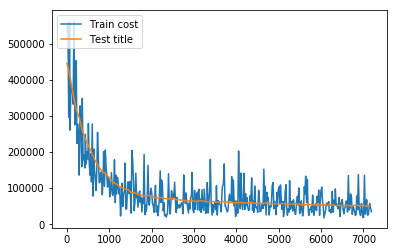

<Figure size 432x288 with 0 Axes>

In [62]:
train_reader=paddle.batch(
    paddle.reader.shuffle(
        train(),
        buf_size=500),
    batch_size=20)
test_reader=paddle.batch(
    paddle.reader.shuffle(
        test(),
        buf_size=500),
    batch_size=20)
trainer=fluid.contrib.trainer.Trainer(
    train_func=train_program,
    place=place,
    optimizer_func=optimizer_program)
trainer.train(
    reader=train_reader,num_epochs=100,
    feed_order=feed_order,
    event_handler=event_handler_plot)

# 1. 第一次作业